In [1]:
import tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Import Dataset

In [3]:
df = pd.read_csv("C:/Users/clayton/OneDrive - Blackstone Products LLC/Documents/Python Scripts/School/IS_6950/Items Shipped.csv")

C:\Users\clayton\AppData\Local\Temp\ipykernel_18536\681835017.py:1: DtypeWarning: Columns (10,17,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/clayton/OneDrive - Blackstone Products LLC/Documents/Python Scripts/School/IS_6950/Items Shipped.csv")


In [4]:
# converting ship date to pandas datetime
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# filtering to the conditioner item
item = '5017'
filtered_df = df[(df['Item'] == item) & (df['Import/Domestic'] == 'Domestic')]
# # grouping quantity to frequency of month
new_df = filtered_df.groupby(pd.Grouper(key='Ship Date', freq="M"))['Quantity'].sum().reset_index()
new_df.set_index('Ship Date', inplace=True)
new_df.head()

,Quantity
Ship Date,
2020-01-31,16593.0
2020-02-29,52589.0
2020-03-31,26165.0
2020-04-30,26650.0
2020-05-31,32738.0


## Splitting the data

In [5]:
len(new_df)

53

In [6]:
num_train_samples = int(0.6 * len(new_df))
num_val_samples = int(0.20 * len(new_df))
num_test_samples = len(new_df) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 31
num_val_samples: 10
num_test_samples: 12


## Preparing the data

### Stationarity

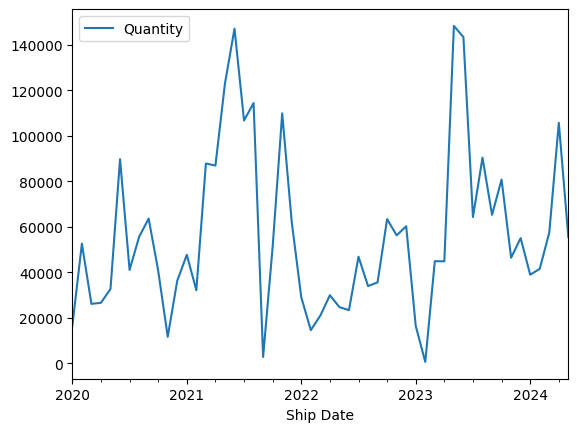

In [7]:
new_df.plot()
plt.show()

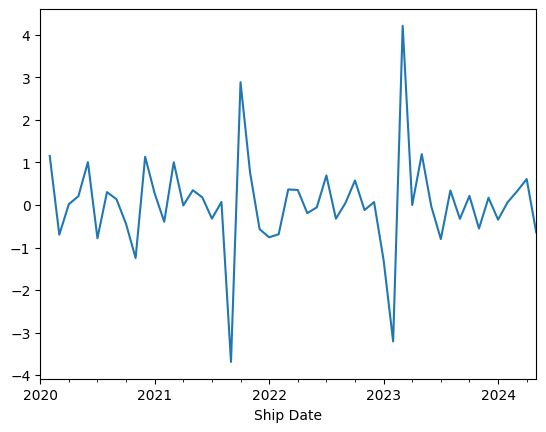

In [8]:
new_df['LogQuantity'] = np.log(new_df['Quantity'])
new_df['DiffLogQuantity']= new_df['LogQuantity'].diff(1)

new_df['DiffLogQuantity'].plot()
plt.show()

In [9]:
new_df.dropna(inplace=True) # when differencing, the first row will be NaN so we need to drop na's

In [10]:
new_df.head()

,Quantity,LogQuantity,DiffLogQuantity
Ship Date,,,
2020-02-29,52589.0,10.870262,1.153526
2020-03-31,26165.0,10.172178,-0.698084
2020-04-30,26650.0,10.190544,0.018367
2020-05-31,32738.0,10.396292,0.205747
2020-06-30,89728.0,11.404538,1.008246


## Time series batch generator

##### This dummy_dataset is an example

try changing batch size and h values to see how that changes the shape etc.

In [11]:
from tensorflow import keras

int_sequence = np.arange(11)
batch_size = 1 # number of time series samples in each batch
sequence_length = 1 # length of the output series (length of memory to pass to RNN)
h = 1 # number of h steps ahead for forecasting
delay = sequence_length + h - 1 # number of delayed timesteps to start predictions

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-delay],
    targets=int_sequence[delay:],
    sequence_length=sequence_length,
    sequence_stride=1, # number of timesteps between two consecutive output sequences
    batch_size=batch_size,
    shuffle=False # whether to shuffle output sequences or keep them in chronological order
)

for inputs, targets in dummy_dataset:
    print(inputs, targets)

tf.Tensor([[0]], shape=(1, 1), dtype=int32) tf.Tensor([1], shape=(1,), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32) tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([[2]], shape=(1, 1), dtype=int32) tf.Tensor([3], shape=(1,), dtype=int32)
tf.Tensor([[3]], shape=(1, 1), dtype=int32) tf.Tensor([4], shape=(1,), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32) tf.Tensor([5], shape=(1,), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32) tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([[6]], shape=(1, 1), dtype=int32) tf.Tensor([7], shape=(1,), dtype=int32)
tf.Tensor([[7]], shape=(1, 1), dtype=int32) tf.Tensor([8], shape=(1,), dtype=int32)
tf.Tensor([[8]], shape=(1, 1), dtype=int32) tf.Tensor([9], shape=(1,), dtype=int32)
tf.Tensor([[9]], shape=(1, 1), dtype=int32) tf.Tensor([10], shape=(1,), dtype=int32)


In the temperature example the h would be equal to 24 meaning that it will predict the temp at 24 hours from now. Not from now until 24 hours. 

In [12]:
len(new_df)

52

In [13]:
# recall
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 31
num_val_samples: 10
num_test_samples: 12


In [14]:
series = new_df['DiffLogQuantity'] 
sequence_length = 3 # using the past 3 months to predict next month.
h = 1
delay = sequence_length  + h - 1
batch_size = 32
shuffle = True

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=shuffle,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=shuffle,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=shuffle,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [15]:
for inputs, targets in test_dataset:
  print(inputs, targets)

tf.Tensor(
[[ 0.17054231 -0.34524654  0.06367243]
 [ 0.21319273 -0.5537368   0.17054231]
 [-0.80180195  0.34065626 -0.32569732]
 [-0.32569732  0.21319273 -0.5537368 ]
 [ 0.34065626 -0.32569732  0.21319273]
 [-0.5537368   0.17054231 -0.34524654]], shape=(6, 3), dtype=float64) tf.Tensor([ 0.3240134  -0.34524654  0.21319273  0.17054231 -0.5537368   0.06367243], shape=(6,), dtype=float64)


In [16]:
series.iloc[num_train_samples + num_val_samples:]

Ship Date
2023-07-31   -0.801802
2023-08-31    0.340656
2023-09-30   -0.325697
2023-10-31    0.213193
2023-11-30   -0.553737
2023-12-31    0.170542
2024-01-31   -0.345247
2024-02-29    0.063672
2024-03-31    0.324013
2024-04-30    0.609676
2024-05-31   -0.644624
Name: DiffLogQuantity, dtype: float64

In [17]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

samples shape: (29, 3)
targets shape: (29,)


## Common sense baseline

In [18]:
for inputs, targets in test_dataset:
  print(inputs.shape, inputs, targets)

(6, 3) tf.Tensor(
[[ 0.34065626 -0.32569732  0.21319273]
 [-0.32569732  0.21319273 -0.5537368 ]
 [ 0.17054231 -0.34524654  0.06367243]
 [-0.80180195  0.34065626 -0.32569732]
 [-0.5537368   0.17054231 -0.34524654]
 [ 0.21319273 -0.5537368   0.17054231]], shape=(6, 3), dtype=float64) tf.Tensor([-0.5537368   0.17054231  0.3240134   0.21319273  0.06367243 -0.34524654], shape=(6,), dtype=float64)


In [19]:
sample_seen = 0
total_abs_err = 0.
for inputs, targets in test_dataset:
  preds = inputs[:, -1]
  sample_seen += inputs.shape[0]


print(sample_seen)
print(preds)

6
tf.Tensor([ 0.06367243  0.21319273 -0.34524654  0.17054231 -0.32569732 -0.5537368 ], shape=(6,), dtype=float64)


In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. # Initializes a variable to accumulate the total absolute error of the predictions. This is a floating-point variable, as indicated by the .0.
    samples_seen = 0   # Initializes a counter for the total number of samples (data points) seen during the evaluation.
    for samples, targets in dataset:
        preds = samples[:, -1] # naive forecast is the last value observed in the sequence
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0] # number of samples in the batch
    return total_abs_err / samples_seen

In [21]:
print(f"Train MAE: {evaluate_naive_method(train_dataset):.2f}")
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

# this unit is DiffLogQuantity

Train MAE: 1.07
Validation MAE: 2.29
Test MAE: 0.54


## Simple RNN

In [22]:
from tensorflow.keras import layers

In [23]:
sequence_length

3

In [24]:
n_features = 1

In [25]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# parameters = (1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms
1*16 + 16*16 + 16

288

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint("RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/200


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9949 - mae: 0.6066 - val_loss: 3.3888 - val_mae: 1.3449
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.9634 - mae: 0.5989 - val_loss: 3.3631 - val_mae: 1.3470
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.9465 - mae: 0.5978 - val_loss: 3.3446 - val_mae: 1.3488
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.9345 - mae: 0.5967 - val_loss: 3.3302 - val_mae: 1.3504
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.9250 - mae: 0.5950 - val_loss: 3.3185 - val_mae: 1.3519
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.9171 - mae: 0.5941 - val_loss: 3.3086 - val_mae: 1.3531
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.9104 - mae: 0.5939 - val_loss: 3.3000 - val_mae: 1.3542
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.9044 - mae: 0.5943 - val_loss: 3.2926 - val_mae: 1.3552
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.8991 - mae: 0.5945

In [28]:
model = keras.models.load_model("RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - loss: 0.0649 - mae: 0.1804
Test MAE: 0.180


In [29]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()

,loss,mae,val_loss,val_mae
195,0.531638,0.446106,3.382556,1.388797
196,0.530608,0.446325,3.397095,1.389600
197,0.529586,0.445365,3.390806,1.390035
198,0.528579,0.445273,3.401858,1.390333
199,0.527580,0.444670,3.399913,1.391338


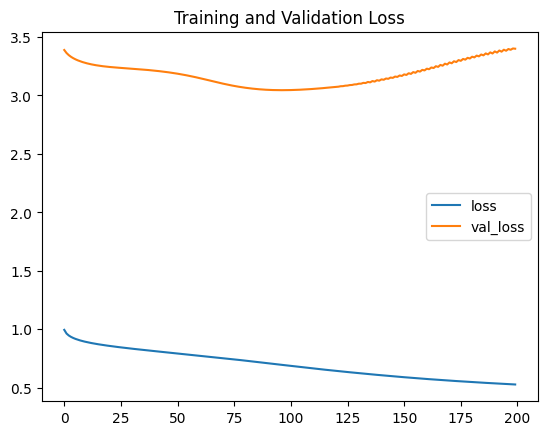

In [30]:
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

The val_loss looks terrible from my understanding. It doesn't get close to the training loss and actually increases. 

The large gap indicates overfitting?

I read that if the val_loss begins to increase we can apply early stopping to prevent overfitting? 

## LSTM

In [31]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# parameters = [(1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms ] * 4 gates
(1*16 + 16*16 + 16) *4

1152

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint("LSTM.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.0735 - mae: 0.6618 - val_loss: 3.9795 - val_mae: 1.3662
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 1.0672 - mae: 0.6595 - val_loss: 3.9639 - val_mae: 1.3645
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.0628 - mae: 0.6580 - val_loss: 3.9510 - val_mae: 1.3631
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1.0591 - mae: 0.6568 - val_loss: 3.9397 - val_mae: 1.3619
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.0559 - mae: 0.6557 - val_loss: 3.9294 - val_mae: 1.3608
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.0529 - mae: 0.6548 - val_loss: 3.9198 - val_mae: 1.3597
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.0502 - mae: 0.6539 - val_loss: 3.9108 - val_mae: 1.3588
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.0476 - mae: 0.6531 - val_loss: 3.9022 - val_mae: 1.3578
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.0452 -

In [34]:
model = keras.models.load_model("LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0682 - mae: 0.2086
Test MAE: 0.209


In [35]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()

,loss,mae,val_loss,val_mae
195,0.758420,0.551157,2.860741,1.282333
196,0.757546,0.550605,2.857768,1.281731
197,0.756684,0.550052,2.854800,1.281124
198,0.755834,0.549504,2.851857,1.280514
199,0.754996,0.548952,2.848904,1.279897


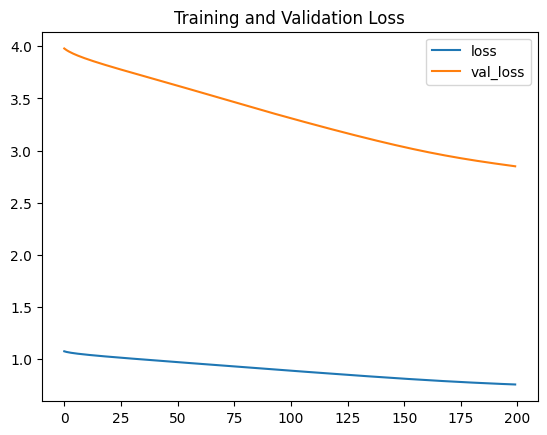

In [36]:
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

## More complex models with regularization

In [37]:
# We can stack multiple LSTM layers and add regularization.

inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(32, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, recurrent_dropout=0.1)(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("RNN_stacked_regularized.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.6225 - mae: 0.9110 - val_loss: 4.4406 - val_mae: 1.4425
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.2366 - mae: 0.6925 - val_loss: 4.2381 - val_mae: 1.4504
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.8811 - mae: 0.5735 - val_loss: 4.1533 - val_mae: 1.4466
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.0538 - mae: 0.6958 - val_loss: 4.0954 - val_mae: 1.4290
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.9659 - mae: 0.6720 - val_loss: 4.0809 - val_mae: 1.4122
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.0700 - mae: 0.6826 - val_loss: 4.0086 - val_mae: 1.4168
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1.1284 - mae: 0.7186 - val_loss: 3.9567 - val_mae: 1.4146
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.9321 - mae: 0.5710 - val_loss: 3.9382 - val_mae: 1.3995
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.8566 -

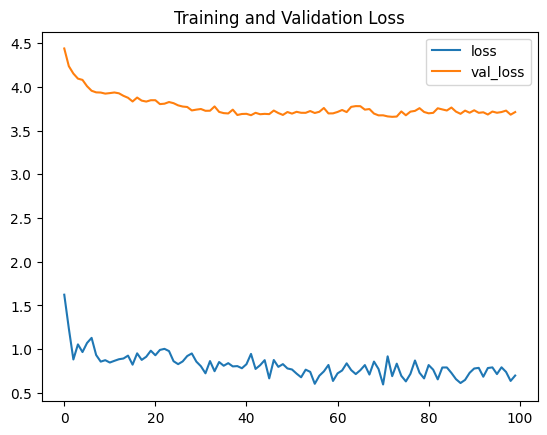

In [38]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

In [39]:
model = keras.models.load_model("RNN_stacked_regularized.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1150 - mae: 0.2294
Test MAE: 0.229


## Bidirectional RNN

In [40]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.Bidirectional(layers.SimpleRNN(32))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("bidirectional_RNN.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8983 - mae: 0.5786 - val_loss: 3.5957 - val_mae: 1.4613
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.8766 - mae: 0.5978 - val_loss: 3.5339 - val_mae: 1.4234
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.8618 - mae: 0.5682 - val_loss: 3.5083 - val_mae: 1.4264
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.8514 - mae: 0.5836 - val_loss: 3.5020 - val_mae: 1.4157
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.8430 - mae: 0.5649 - val_loss: 3.4683 - val_mae: 1.4106
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.8356 - mae: 0.5769 - val_loss: 3.4686 - val_mae: 1.4047
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.8288 - mae: 0.5631 - val_loss: 3.4429 - val_mae: 1.3989
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.8226 - mae: 0.5697 - val_loss: 3.4401 - val_mae: 1.3944
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.8168 -

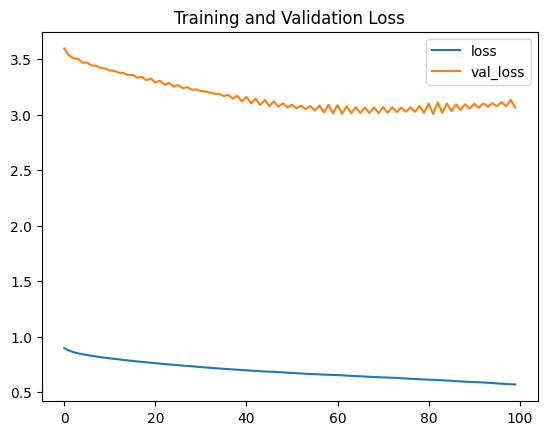

In [41]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

In [42]:
model = keras.models.load_model("bidirectional_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step - loss: 0.1220 - mae: 0.2386
Test MAE: 0.239


In [43]:
print(f"Test MAE: {keras.models.load_model('bidirectional_RNN.keras').evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step - loss: 0.1220 - mae: 0.2386
Test MAE: 0.239


It appears the simple RNN performed the best. 

I tried different batch numbers, layers, and sequence lenghts. I couldn't beat the 0.19 MSE that the original parameters were. 